In [ ]:
!pip install yfinance
!pip install starfishX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import starfishX as sx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm
import math
import pandas as pd
import datetime

# 1.

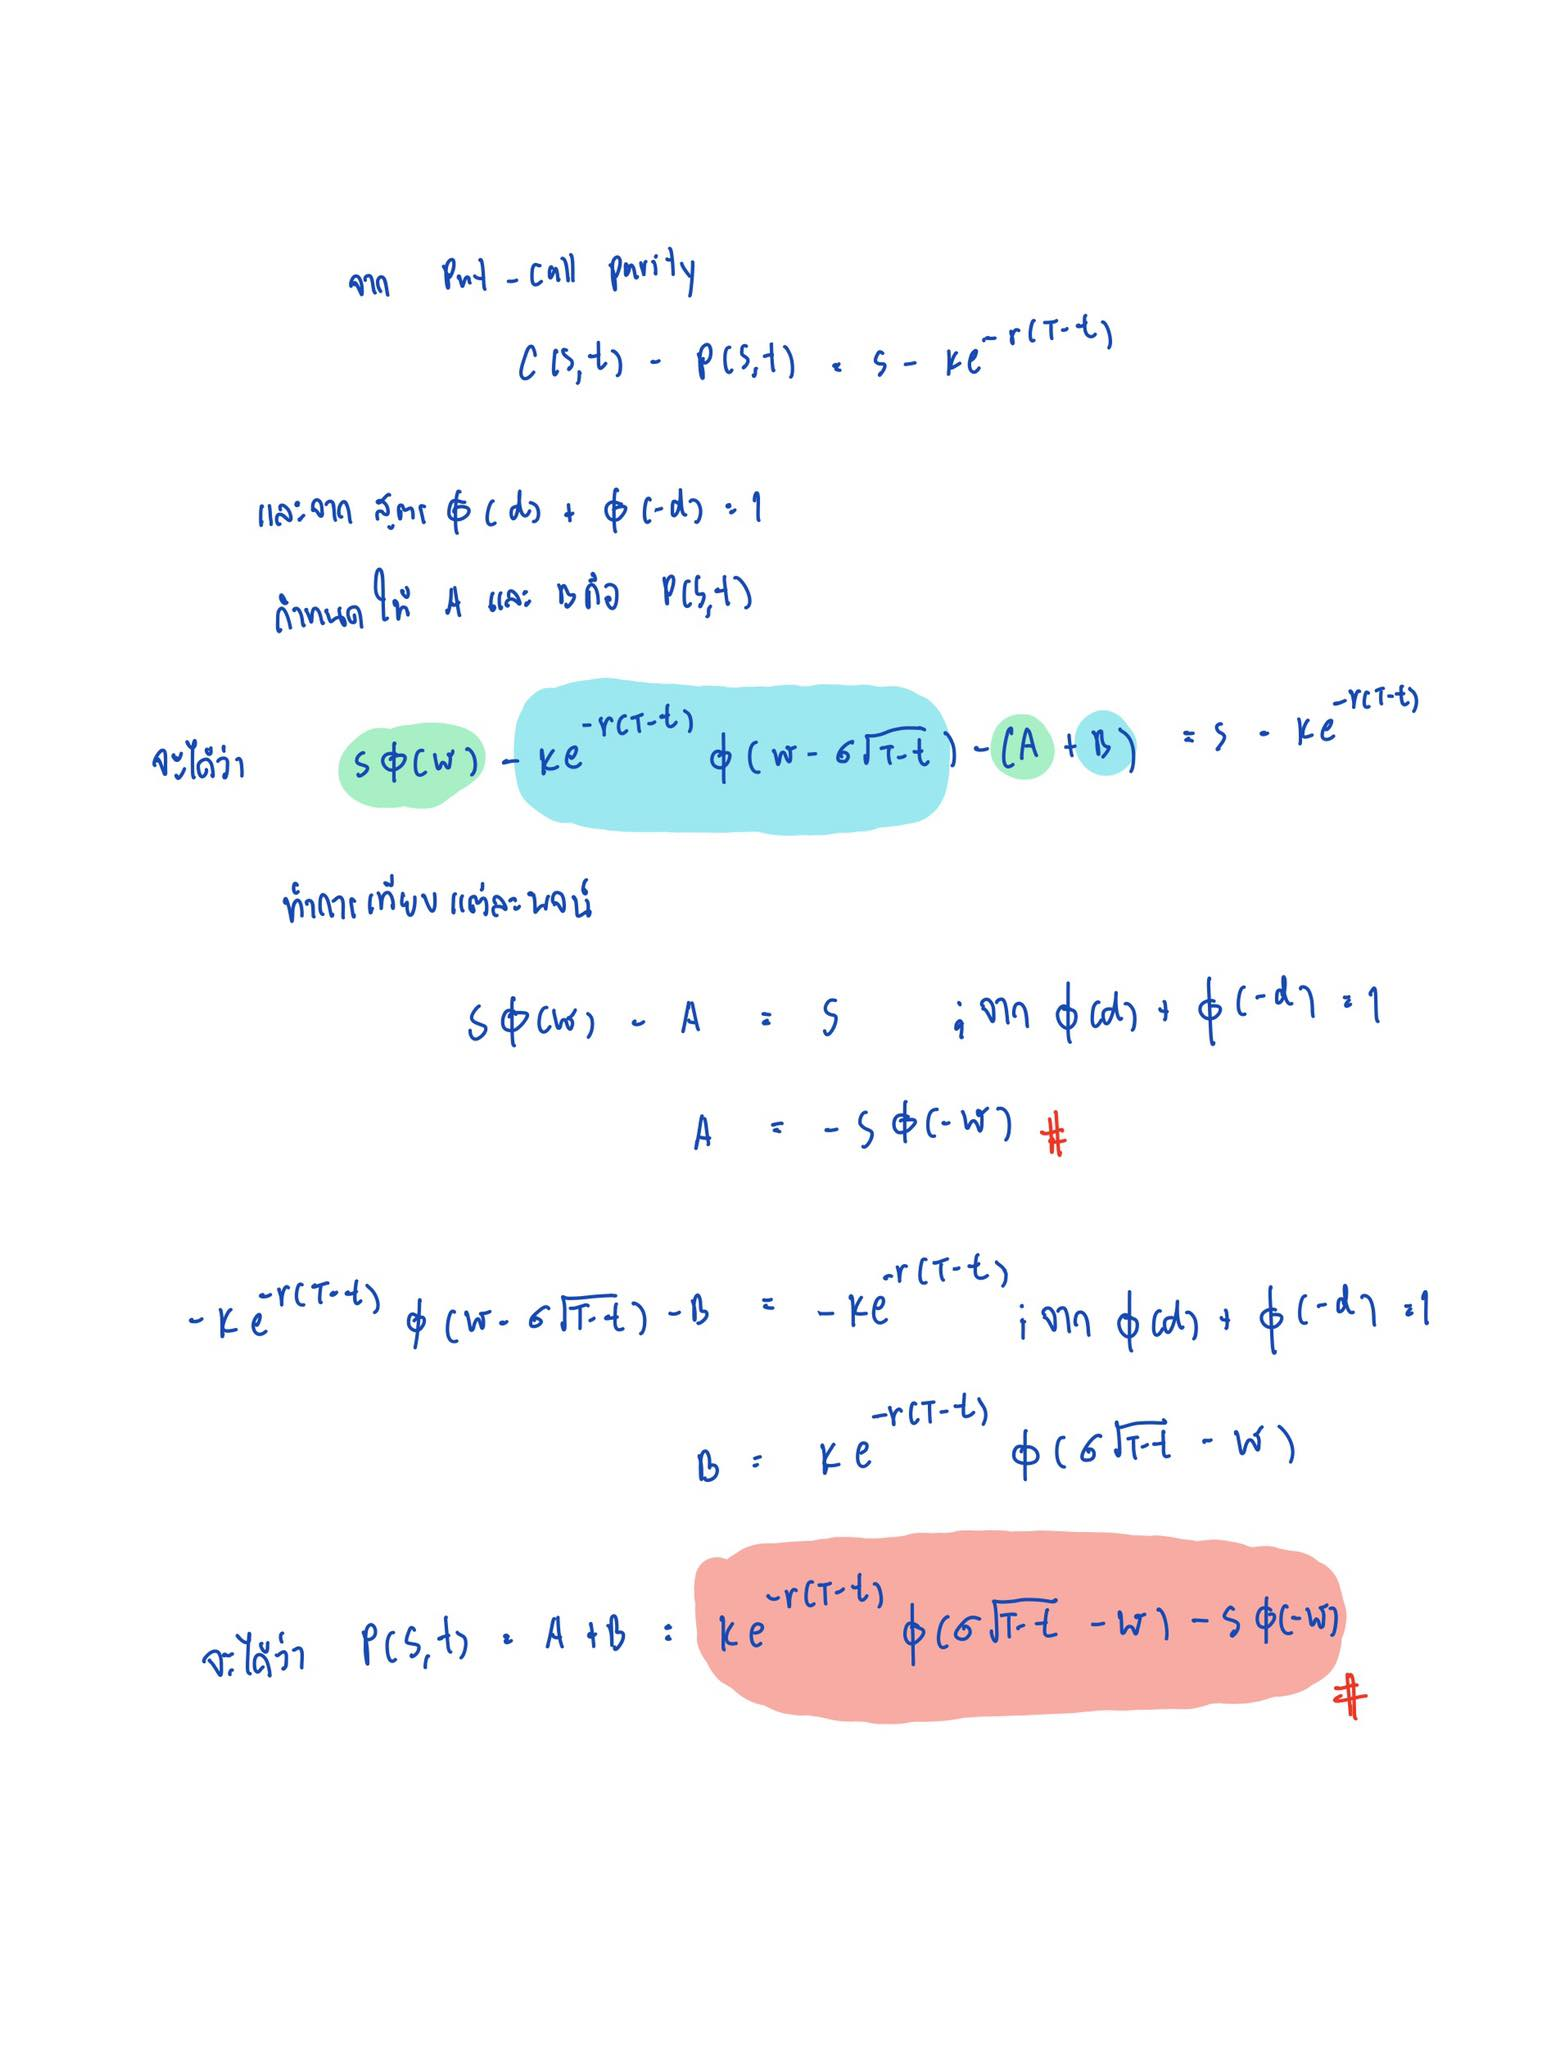

# 2. Write a python code to price call and put options with no dividend, constant volatility and constant risk-free rate, and also Greeks.

## d1 & d2

In [ ]:
def find_d(S, K, r, sigma, t):
  d1 = (np.log(S/K) + (r + (sigma**2/2)) * (t)) / (sigma * np.sqrt(t))
  d2 = (np.log(S/K) + (r - (sigma**2/2)) * (t)) / (sigma * np.sqrt(t))
  
  return d1, d2

## Call

In [ ]:
def Call_Option(S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return S*norm.cdf(d1) - K*math.exp(-1*r*t)*norm.cdf(d2)
  

In [ ]:
Call_Option(62, 60, 0.1, 0.2, 5/12)

5.7977812415148975

## Put

In [ ]:
def Put_Option(S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return K*math.exp(-1*r*t)*norm.cdf(-1*d2) - S*norm.cdf(-1*d1)

In [ ]:
Put_Option(97, 95, 0.08, 0.45, 1/4)

6.7134263252968935

## Greeks


### Delta

In [ ]:
#Call
def Delta_call_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return norm.cdf(d1)

In [ ]:
#Put
def Delta_put_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return norm.cdf(d1) - 1

### Gamma

In [ ]:
def Gamma_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return norm.pdf(d1, 0, 1) / (S*sigma*np.sqrt(t))

### Vega

In [ ]:
def Vega_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return S*norm.pdf(d1, 0, 1)*np.sqrt(t)

### Theta

In [ ]:
def Theta_call_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(t)) - r*K*np.exp(-r*t)*norm.cdf(d2, 0, 1)

In [ ]:
def Theta_put_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(t)) + r*K*np.exp(-r*t)*norm.cdf(-d2, 0, 1)

### Rho

In [ ]:
def Rho_call_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return K*t*np.exp(-r*t)*norm.cdf(d2, 0, 1)

In [ ]:
def Rho_put_cal (S, K, r, sigma, t):
  d1, d2 = find_d(S, K, r, sigma, t)

  return -K*t*np.exp(-r*t)*norm.cdf(-d2, 0, 1)

# 3.Write a code to get one DW data in SET and calculate implied volatility. Compare with historical volatility from Homework 2, analyze if this DW is good to invest or not, and explain why.

In [ ]:
df = yf.download(tickers='ESSO.BK', interval='1d', start='2022-05-03', end='2022-08-22', auto_adjust=True)[['Close']].ffill()
df['returns'] = df['Close'].pct_change()
df.tail()

[*********************100%***********************]  1 of 1 completed


,Close,returns
Date,,
2022-08-15,11.2,0.027523
2022-08-16,11.6,0.035714
2022-08-17,12.0,0.034483
2022-08-18,12.1,0.008333
2022-08-19,12.3,0.016529


In [ ]:
df.dropna().std()['returns']

0.028558968578333364

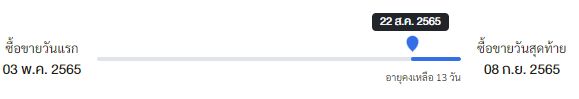

In [ ]:
dw = sx.getDW('ESSO13C2209A')
dw.dropna(inplace=True)
dw.head()

,open,close,high,low,change,percentChange,totalVolume,totalValue
date,,,,,,,,
2022-08-22 00:00:00+07:00,0.55,0.63,0.67,0.55,0.18,40.00,7306900.0,4590203.0
2022-08-18 00:00:00+07:00,0.52,0.45,0.52,0.45,-0.01,-2.17,4459000.0,2272660.0
2022-08-17 00:00:00+07:00,0.46,0.46,0.46,0.46,0.19,70.37,100000.0,46000.0
2022-08-16 00:00:00+07:00,0.27,0.27,0.27,0.27,0.07,35.00,300.0,81.0
2022-07-15 00:00:00+07:00,0.23,0.20,0.23,0.18,-0.20,-50.00,6002500.0,1210450.0


In [ ]:
#ประมาณราคา dw ตั้งเเต่ปัจจุบัน จนถึง maturity date
price = []
for i in range(13, 0, -1):
  S = 12.3
  K = 12
  r = 0.025
  sigma = df.dropna().std()['returns']
  t = i / 365
  price.append(Call_Option(S, K, r, sigma, t))

price1 = pd.DataFrame(price)

for i in range(len(dw)):
  price.append(dw.iloc[i]['close'])

price2 = pd.DataFrame(price)
price2

,0
0,0.310680
1,0.309859
2,0.309038
3,0.308216
4,0.307395
...,...
57,0.310000
58,0.340000
59,0.360000
60,0.360000


In [ ]:
print(f'historical vol of dw = {dw.std()["close"]}')
print(f'historical vol of ticker = {df.std()["returns"]}')
print(f'implied vol of dw = {price1.std()}')
print(f'implied vol(old-future) of dw = {price2.std()}')

historical vol of dw = 0.19878799427195465
historical vol of ticker = 0.028558968578333364
implied vol of dw = 0    0.003199
dtype: float64
implied vol(old-future) of dw = 0    0.192104
dtype: float64


จะเห็นได้ว่า implied volatility ที่ได้มามีค่าใกล้เคียงกับ historical volatility ของหุ้น เนื่องจากการเปลี่ยนเเปลงของราคาหุ้น ทำให้ราคาของ option ต่างๆ เปลี่ยนเเปลงไป ถ้าเป็น call option จะมีความสัมพันธ์ที่เป้นบวกต่อกัน เเละ implied vol ในอดีตจะมีความใกล้เคียงกันกับ ราคา historical price ของ dw ในอดีต ถือว่าเป็นหุ้นที่ โดยยังไม่ค่อยมีความน่าลงทุนมากนักเนื่องจาก implied volatility ที่ได้มีค่าค่อนข้างต่ำ อาจจะไม่ได้ทำให้ไปอยู่ในช่วง in-the-money


# 4.Suppose you are working in a bank. The bank wants you to write a call option. Thus, at the expiration date, your bank must make sure that it has enough stocks to deliver if the option is in the money. Choose one European option from any market and perform hedging once a week. Since it is quite difficult to find an European option in US market, you may find a European option from Indian index, SET 50 DW, or a DW in SET. Plot and show weekly Greeks. Analyze what has happened related to Greeks. Calculate profit&loss from writing this option at the theoretical price from Black-Sholes pricing

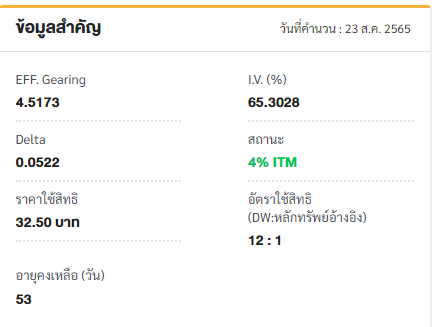

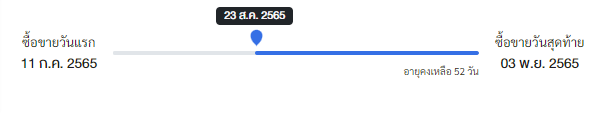

In [ ]:
df3 = yf.download(tickers='COM7.BK', interval='1d', start='2020-07-11', end='2022-07-11', auto_adjust=True)[['Close']].ffill()
df3['returns'] = df3['Close'].pct_change()
df3.std()['returns']

[*********************100%***********************]  1 of 1 completed


0.02301605874579197

In [ ]:
df2 = yf.download(tickers='COM7.BK', interval='1wk', start='2022-07-11', end='2022-08-22', auto_adjust=True)[['Close']].ffill()
df2['returns'] = df2['Close'].pct_change()
df2['date'] = pd.to_datetime(df2.index)
df2.head()

[*********************100%***********************]  1 of 1 completed


,Close,returns,date
Date,,,
2022-07-11,28.50,NaN,2022-07-11
2022-07-18,29.75,0.043860,2022-07-18
2022-07-25,30.50,0.025210,2022-07-25
2022-08-01,33.50,0.098361,2022-08-01
2022-08-08,33.25,-0.007463,2022-08-08


In [ ]:
dw2 = sx.getDW('COM741C2211A')
dw2['date'] = pd.to_datetime(dw2.index)
dw2.dropna(inplace=True)
dw2['date'] = dw2['date'].dt.strftime('%Y-%m-%d')
dw2['date'] = pd.to_datetime(dw2['date'])
dw2['end_date'] = ['2022-05-03' for i in range(len(dw2))]
dw2['end_date'] = pd.to_datetime(dw2['end_date'])

dw2['weekDiff'] = (dw2['date'] - dw2['end_date']) / np.timedelta64(1, 'W')

dw2.head()

,open,close,high,low,change,percentChange,totalVolume,totalValue,date,end_date,weekDiff
date,,,,,,,,,,,
2022-08-22 00:00:00+07:00,0.39,0.39,0.40,0.37,-0.01,-2.50,4000200.0,1563137.0,2022-08-22,2022-05-03,15.857143
2022-08-19 00:00:00+07:00,0.42,0.40,0.44,0.40,-0.01,-2.44,732800.0,312108.0,2022-08-19,2022-05-03,15.428571
2022-08-18 00:00:00+07:00,0.42,0.41,0.42,0.40,-0.03,-6.82,2128400.0,886175.0,2022-08-18,2022-05-03,15.285714
2022-08-17 00:00:00+07:00,0.40,0.44,0.44,0.38,0.04,10.00,1270400.0,529651.0,2022-08-17,2022-05-03,15.142857
2022-08-16 00:00:00+07:00,0.36,0.40,0.40,0.35,0.04,11.11,1246000.0,490300.0,2022-08-16,2022-05-03,15.000000


In [ ]:
dw2['date'] = pd.to_datetime(dw2['date'])
df2['date'] = pd.to_datetime(df2['date'])

In [ ]:
dw2 = dw2[dw2.date.isin(df2.date)]
dw2['weekDiff'] = dw2['weekDiff'] // 1
dw2.head()

,open,close,high,low,change,percentChange,totalVolume,totalValue,date,end_date,weekDiff
date,,,,,,,,,,,
2022-08-15 00:00:00+07:00,0.32,0.36,0.36,0.32,-0.04,-10.00,4270800.0,1488830.0,2022-08-15,2022-05-03,14.0
2022-08-08 00:00:00+07:00,0.38,0.37,0.38,0.36,-0.03,-7.50,3283000.0,1231218.0,2022-08-08,2022-05-03,13.0
2022-08-01 00:00:00+07:00,0.28,0.39,0.39,0.28,0.12,44.44,13787600.0,4727468.0,2022-08-01,2022-05-03,12.0
2022-07-25 00:00:00+07:00,0.27,0.31,0.32,0.27,0.04,14.81,7234600.0,2092016.0,2022-07-25,2022-05-03,11.0
2022-07-18 00:00:00+07:00,0.23,0.19,0.23,0.19,-0.04,-17.39,9902400.0,2099473.0,2022-07-18,2022-05-03,10.0


In [ ]:
df2 = df2[df2.date.isin(dw2.date)]
df2

,Close,returns,date
Date,,,
2022-07-11,28.50,NaN,2022-07-11
2022-07-18,29.75,0.043860,2022-07-18
2022-07-25,30.50,0.025210,2022-07-25
2022-08-01,33.50,0.098361,2022-08-01
2022-08-08,33.25,-0.007463,2022-08-08
2022-08-15,34.00,0.022556,2022-08-15


In [ ]:
hedge = pd.DataFrame({'Week':[], 'S':[], 'Delta':[], 'Shares':[], 'Interest Cost':[], 'Cum cost':[]})
hedge

,Week,S,Delta,Shares,Interest Cost,Cum cost


In [ ]:
week = int(0)

#shares
num = 10000

for i in range(len(dw2)):
  delta = Delta_call_cal(df2.iloc[i]['Close'], 32.5, 0.025, 0.023016, dw2.iloc[i]['weekDiff'] / 52)
  cost = delta * num * dw2.iloc[i]['close'] * (np.exp(0.025/52) - 1)

  hedge.loc[len(hedge.index)] = [week, df2.iloc[i]['Close'], delta, delta*num, cost, 0]
  week+=1

hedge

,Week,S,Delta,Shares,Interest Cost,Cum cost
0,0.0,28.50,9.249748e-26,9.249748e-22,1.601303e-25,0.0
1,1.0,29.75,4.884936e-13,4.884936e-09,8.691638e-13,0.0
2,2.0,30.50,9.087151e-08,9.087151e-04,1.704250e-07,0.0
3,3.0,33.50,9.996210e-01,9.996210e+03,1.490178e+00,0.0
4,4.0,33.25,9.969447e-01,9.969447e+03,9.108895e-01,0.0
5,5.0,34.00,9.999999e-01,9.999999e+03,1.009858e+00,0.0


In [ ]:
hedge.loc[0, 'Cum cost'] = hedge.iloc[0]['Shares'] * hedge.iloc[0]['S']

for i in range(1, len(hedge)):
  sum = (hedge.iloc[i-1]['Shares'] - hedge.iloc[i]['Shares']) * hedge.iloc[i]['S']
  cost = hedge.iloc[i-1]['Cum cost'] - sum + hedge.iloc[i-1]['Cum cost']
  hedge.loc[i, 'Cum cost'] = cost
hedge

hedge

,Week,S,Delta,Shares,Interest Cost,Cum cost
0,0.0,28.50,9.249748e-26,9.249748e-22,1.601303e-25,2.636178e-20
1,1.0,29.75,4.884936e-13,4.884936e-09,8.691638e-13,1.453268e-07
2,2.0,30.50,9.087151e-08,9.087151e-04,1.704250e-07,2.771595e-02
3,3.0,33.50,9.996210e-01,9.996210e+03,1.490178e+00,3.348731e+05
4,4.0,33.25,9.969447e-01,9.969447e+03,9.108895e-01,6.688562e+05
5,5.0,34.00,9.999999e-01,9.999999e+03,1.009858e+00,1.338751e+06


In [ ]:
PF = 32.5*num + 0.36*num - 1.338751e+06
PF

-1010151.0

ขาดทุน = -1010151 บาท

ไม่สามารถ plot graph ได้เนื่องจากค่าที่ได้มีจำนวนเเตกต่างกันเกินไป โดยจะเห็นว่าในช่วงเเรกที่ S มีค่าน้อยกว่า Strike price ค่า delta จะมีค่าที่น้อยมาก เนื่องจากราคาของ option น่าจะตกลง จึงไม่มีคนซื้อไม่เเนะนำให้ตุนหุ้น เเต่เมื่อค่าของ S เพิ่มมากขึ้นจนมากกว่า strike price จะเห็นได้ว่าค่า delta เพิ่มขึ้นอย่างมาก คือควรจะตุนหุ้นที่ราคานี้ไว้ เพื่อกันราคาหุ้นขึ้นสูงกว่าเดิม จะได้ไม่ต้องไปซื้อมาขาย ณ จุดที่ราคาสูง

# 5. Pick one DW and choose option strategies to trade the DW. Use DW historical data to demonstrate how the strategies works or does not work.

In [ ]:
import seaborn as sns



In [ ]:
dw4 = sx.getDW('ESSO13C2209A')
sns.lineplot(y=dw4['close'].dropna())

In [ ]:
dw4

,open,close,high,low,change,percentChange,totalVolume,totalValue
date,,,,,,,,
2022-08-22 00:00:00+07:00,0.55,0.63,0.67,0.55,0.18,40.00,7306900.0,4590203.0
2022-08-19 00:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-18 00:00:00+07:00,0.52,0.45,0.52,0.45,-0.01,-2.17,4459000.0,2272660.0
2022-08-17 00:00:00+07:00,0.46,0.46,0.46,0.46,0.19,70.37,100000.0,46000.0
2022-08-16 00:00:00+07:00,0.27,0.27,0.27,0.27,0.07,35.00,300.0,81.0
...,...,...,...,...,...,...,...,...
2022-05-10 00:00:00+07:00,0.32,0.31,0.32,0.26,-0.03,-8.82,10517100.0,3118993.0
2022-05-09 00:00:00+07:00,0.34,0.34,0.38,0.34,-0.02,-5.56,14895300.0,5327287.0
2022-05-06 00:00:00+07:00,0.34,0.36,0.36,0.32,0.00,0.00,19530400.0,6585534.0


เนื่องจากลอง plot graph โดยใช้หลาย tools เเล้วเเต่กราฟไม่ขึ้น เลยขอนำรูปกราฟมาแปะเเทนครับ

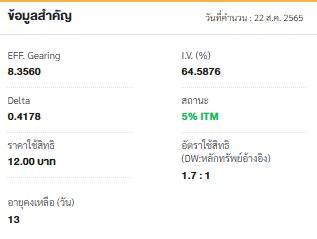

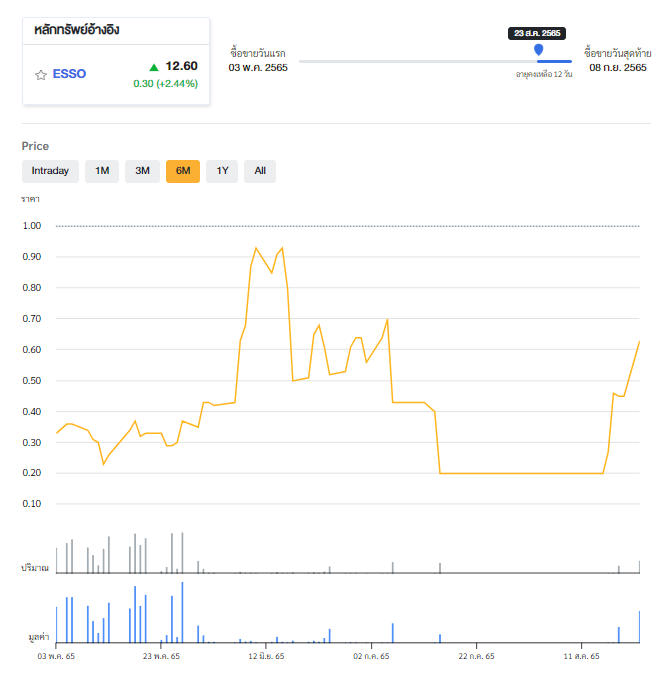

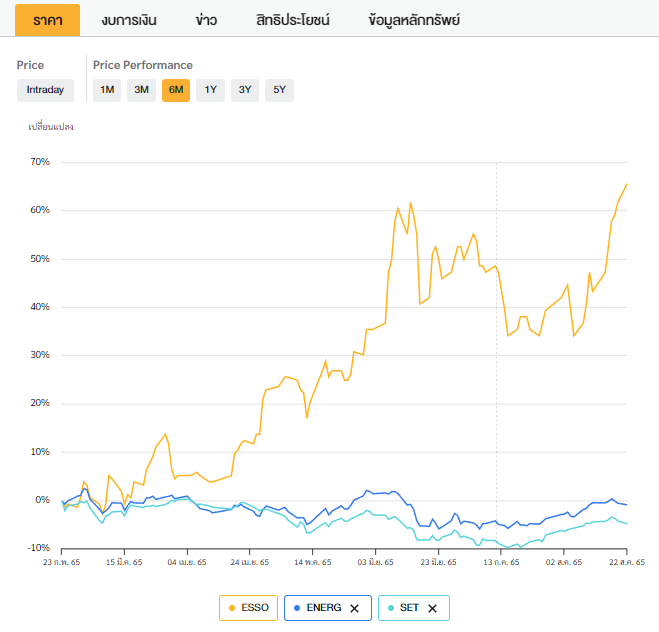

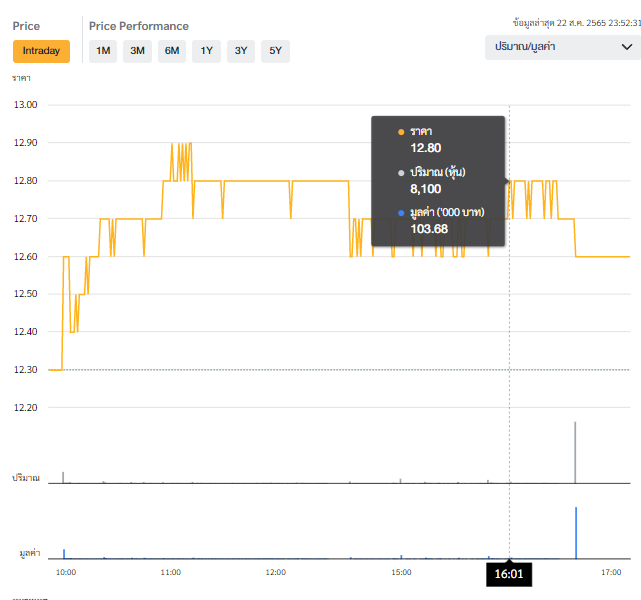

จะเลือกใช้กลยุทธ์ longcall option โดยการซื้อ option ไว้ เนื่องจาก ราคาของ ESSO ในปัจจุบัน มีราคา 12.8 โดยประมาณเเต่หากเราซื้อ option ไว้จะมีราคา exercise อยู่ที่ 12 โดยกาหคิดรวมกับค่า premium เเล้วก็ไม่มีทางถึง 12.8 อย่างเเน่นอน